In [4]:
import torch
from torchvision import datasets

In [14]:
# Path to your dataset
dataset_path = 'train_data_2&3d\images_224x224'

In [15]:
from torchvision import transforms

transform = transforms.Compose([
    # transforms.Resize((224, 224)),  # Resize all images to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [16]:
# dataset[0][0].shape

In [17]:
# Path to your dataset
targets_path = 'train_data_2&3d\scaled_13x13x15'

In [18]:
import numpy as np


# transform_target = transforms.Compose([
#     # transforms.Resize((64, 64)),  # Resize all images to 64x64
#     # transforms.ToTensor(),
#     # transforms.ToFloat(),
#     # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

def npy_loader(path):

     # Load the data from a .npy file
    sample = np.load(path)

    # Convert the numpy array from int to float32
    sample = sample.astype(np.float32)

    # Convert numpy array to a PyTorch tensor
    sample = torch.from_numpy(sample)

    # Optionally, normalize the data here if required
    # sample = (sample - sample.mean()) / sample.std()

    return sample

    # sample = torch.from_numpy(np.load(path))
    # return sample


# Create the dataset
targets = datasets.DatasetFolder(root=targets_path, loader=npy_loader, extensions=['.npy'])

In [19]:
# DataLoader
batch_size = 16  # Batch size

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
targetloader = torch.utils.data.DataLoader(targets, batch_size=batch_size, shuffle=False)

In [20]:
# from torchvision import models
#
# vgg19 = models.vgg19(pretrained=True)
# vgg19.eval()

In [21]:
# # Assuming you are using ImageNet classes
# with open('imagenet-classes.txt') as f:  # Make sure to have this file from ImageNet
#     classes = [line.strip() for line in f.readlines()]
#

In [22]:
# # Processing images in the dataloader
# for images, _ in dataloader:
#     outputs = vgg19(images)
#     probabilities = torch.nn.functional.softmax(outputs, dim=1)
#     k = 10  # Set k to whatever number you need, ensure batch size is ≥ k
#     top_prob, top_catid = torch.topk(probabilities, k=k)
#     for i in range(images.size(0)):  # Loop over batch size
#         print(f"Image {i + 1}:")
#         for j in range(k):  # Loop over top k predictions
#             class_id = top_catid[i, j]
#             prob = top_prob[i, j].item() * 100
#             print(f"  Top {j + 1} predicted class: {classes[class_id]}, Probability: {prob:.2f}%")
#     break  # Stop after first batch for demo purposes    break

# Architecture

In [23]:
import torch
import torch.nn as nn
from torchvision import models

class To3Net(nn.Module):
    def __init__(self):
        super(To3Net, self).__init__()
        # Load pre-trained VGG-19, excluding the fully connected layers
        vgg19 = models.vgg19(pretrained=True).features

        # Encoder layers (using VGG-19 features)
        self.enc1 = vgg19[:4]   # Convolution and ReLU activations
        self.enc2 = vgg19[4:9]  # Includes MaxPooling and Conv layers
        self.enc3 = vgg19[9:14] # Includes MaxPooling and Conv layers
        self.enc4 = vgg19[14:23]# Includes MaxPooling and Conv layers
        self.enc5 = vgg19[23:32]# Includes MaxPooling and Conv layers

        # Decoder layers with skip connections
        self.dec5 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(512 + 512, 256, kernel_size=2, stride=2)
        # self.dec3 = nn.ConvTranspose2d(256 + 256, 128, kernel_size=2, stride=2)
        # self.dec2 = nn.ConvTranspose2d(128 + 128, 64, kernel_size=2, stride=2)
        # self.dec1 = nn.ConvTranspose2d(64 + 64, 32, kernel_size=2, stride=2)
        # self.dec1 = nn.ConvTranspose2d(64 + 64, 56, kernel_size=2, stride=2)

        # Output layer
        # self.final = nn.Conv2d(512, 64, kernel_size=1)
        self.dec_3d_1 = nn.Conv3d(1, 1, kernel_size=(2, 2, 3), stride=(1, 1, 2), padding=(0, 0, 0))
        self.pool_3d_1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.dec_3d_2 = nn.Conv3d(1, 1, kernel_size=(2, 2, 2), stride=(1, 1, 2), padding=(0, 0, 0))
        self.pool_3d_2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.final = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)

        # Decoder with skip connections
        dec = self.dec5(enc5)
        # print(dec.shape)
        dec = torch.cat([dec, enc4], dim=1)
        # print(dec.shape)
        dec = self.dec4(dec)
        # print(dec.shape)
        dec = torch.cat([dec, enc3], dim=1)
        # print(dec.shape)
        # dec = self.dec3(dec)
        # print(dec.shape)
        # dec = torch.cat([dec, enc2], dim=1)
        # print(dec.shape)
        # dec = self.dec2(dec)
        # print(dec.shape)
        # dec = torch.cat([dec, enc1], dim=1)
        # print(dec.shape)
        # dec = self.dec1(dec)
        # print(dec.shape)

        # 2d to 3d
        dec = enc3.view(dec.size(0), 1, 256, 56, 56).permute(0, 1, 3, 4, 2)
        # print(dec.shape)

        # 3d convolutions
        dec = self.dec_3d_1(dec)
        # print(dec.shape)
        dec = self.pool_3d_1(dec)
        # print(dec.shape)
        dec = self.dec_3d_2(dec)
        # print(dec.shape)
        dec = self.pool_3d_2(dec)
        # print(dec.shape)
        dec = self.final(dec)
        # print(dec.shape)

        return dec


In [24]:
# Train

In [25]:
# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [26]:
torch.cuda.is_available()

True

In [27]:
# Load the model

In [28]:
# del model
# del optimizer

In [29]:
# del dataloader
# del targetloader

In [30]:
model = To3Net().to(device)
# print(model)

C:\Users\dzmit\anaconda3\envs\kautra\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dzmit\anaconda3\envs\kautra\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
# model(dataset[0][0].to(device).unsqueeze(0)).shape

In [32]:
# dataset[0][0].unsqueeze(0).to('cpu')

In [33]:
import trimesh
import matplotlib.pyplot as plt


def check_output(generated_object, input_image, epoch=0, batch=0):
    generated_object = generated_object.to('cpu').clone().detach() # Move to CPU and detach from the computation graph
    generated_object = (generated_object.numpy() > np.median(generated_object.numpy())).astype(np.uint8) # Convert to numpy array
    print(generated_object.sum())
    generated_object[0][0][0] = 1

    # Save the mesh
    voxel_mesh = trimesh.voxel.ops.matrix_to_marching_cubes(generated_object)
    voxel_mesh.export(f'output/check_generated_object_epoch_{epoch}_batch_{batch}.obj')

     # Normalize the image to [0, 1] if it's not already
    image = input_image.to('cpu').clone().detach().numpy().transpose(1, 2, 0)
    image = (image + 1) / 2  # Assuming that the output is in the range [-1, 1]
    image = image.clip(0, 1)  # Ensure the values are within [0, 1]

    plt.imshow(image)
    plt.savefig(f'output/check_generated_image_epoch_{epoch}_batch_{batch}.png')


def check_normal_output(generated_object, input_image, threshold=0.5, epoch=0, batch=0):
    generated_object = generated_object.to('cpu').clone().detach() # Move to CPU and detach from the computation graph
    generated_object = (generated_object.numpy() > threshold).astype(np.uint8) # Convert to numpy array
    print(generated_object.sum())
    generated_object[0][0][0] = 1

    # Save the mesh
    voxel_mesh = trimesh.voxel.ops.matrix_to_marching_cubes(generated_object)
    voxel_mesh.export(f'output/check_generated_object_epoch_{epoch}_batch_{batch}.obj')

     # Normalize the image to [0, 1] if it's not already
    image = input_image.to('cpu').clone().detach().numpy().transpose(1, 2, 0)
    image = (image + 1) / 2  # Assuming that the output is in the range [-1, 1]
    image = image.clip(0, 1)  # Ensure the values are within [0, 1]

    plt.imshow(image)
    plt.savefig(f'output/check_generated_image_epoch_{epoch}_batch_{batch}.png')


In [34]:
# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, betas=(0.5, 0.999))
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

In [35]:
# # # Load the checkpoint
# checkpoint = torch.load('GAN_199.pth')
#
# # Assuming the generator and discriminator are already instantiated as per the saved model architecture
# generator.load_state_dict(checkpoint['generator_state_dict'])
# discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
#
# # Assuming the optimizers are already instantiated with the parameters of their respective models
# optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
# optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
#
# # If you saved the epoch number, you can also load this to know where to resume training
# epoch = checkpoint['epoch']


492


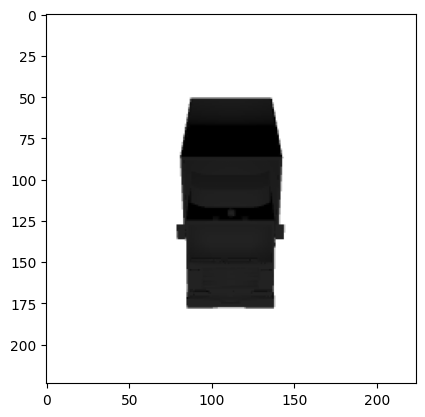

In [36]:
for i, ((images, _), (objects, _)) in enumerate(zip(dataloader, targetloader)):
    check_output(objects[0], images[0], epoch=2000, batch=2000)
    break

In [37]:
num_epochs = 300

In [38]:
for epoch in range(num_epochs):
    try:
        for i, ((images, _), (objects, _)) in enumerate(zip(dataloader, targetloader)):
            # Move data to the appropriate device
            images = images.to(device)
            objects = objects.to(device)

            ### Train Generator
            optimizer.zero_grad()

            output = model(images).squeeze(1)
            loss = criterion(output, objects)
            loss.backward()

            optimizer.step()

            if (epoch + 1) % 4 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], '
                      f'Loss: {loss.item():.4f}')

            if (epoch + 1) % 10 == 0:
                # if (i + 1) % 5 == 0:
                try:
                    check_normal_output(output[0], images[0], epoch=epoch, batch=i)
                except Exception:
                    pass


        #     # check_output(fake_images[0], epoch)
        #     generate_and_plot_images(25, epoch=epoch)

        if (epoch + 1) % 90 == 0:
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch  # Optional, if you want to also save the epoch number
            }

            torch.save(checkpoint, f'GAN_ass_{epoch}.pth')

    except OSError:
        print(f"An error occurred while processing the image. Epoch: {epoch}, batch: {i}")
        continue


Epoch [4/300], Step [1/64], Loss: 0.4875
Epoch [4/300], Step [2/64], Loss: 0.6185
Epoch [4/300], Step [3/64], Loss: 0.2781
Epoch [4/300], Step [4/64], Loss: 0.2682
Epoch [4/300], Step [5/64], Loss: 0.3382
Epoch [4/300], Step [6/64], Loss: 0.4010
Epoch [4/300], Step [7/64], Loss: 0.3424
Epoch [4/300], Step [8/64], Loss: 0.3512
Epoch [4/300], Step [9/64], Loss: 0.3873
Epoch [4/300], Step [10/64], Loss: 0.2236
Epoch [4/300], Step [11/64], Loss: 0.3102
Epoch [4/300], Step [12/64], Loss: 0.4229
Epoch [4/300], Step [13/64], Loss: 0.3055
Epoch [4/300], Step [14/64], Loss: 0.3548
Epoch [4/300], Step [15/64], Loss: 0.4059
Epoch [4/300], Step [16/64], Loss: 0.5039
Epoch [4/300], Step [17/64], Loss: 0.3597
Epoch [4/300], Step [18/64], Loss: 0.2908
Epoch [4/300], Step [19/64], Loss: 0.4518
Epoch [4/300], Step [20/64], Loss: 0.5377
Epoch [4/300], Step [21/64], Loss: 0.3124
Epoch [4/300], Step [22/64], Loss: 0.4457
Epoch [4/300], Step [23/64], Loss: 0.3280
Epoch [4/300], Step [24/64], Loss: 0.6857
E


KeyboardInterrupt



Error in callback <function flush_figures at 0x00000231FF411F30> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



0


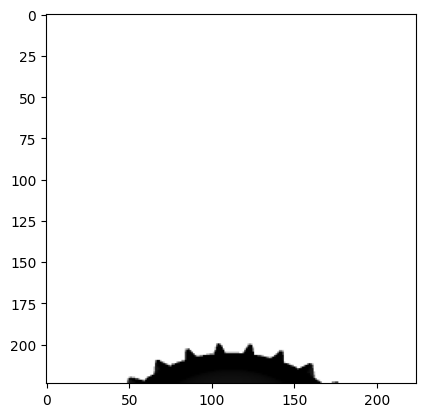

In [40]:
check_normal_output(output[-1], images[-1], epoch=epoch + 1, batch=i + 1)

torch.Size([16, 1, 13, 13, 15])
0


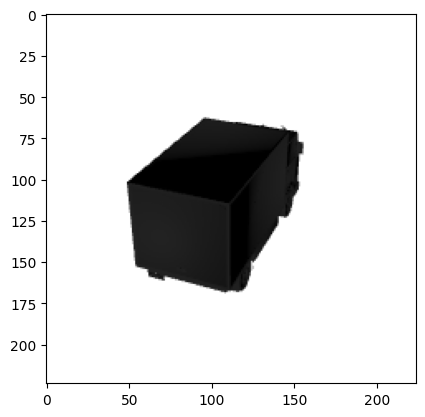

In [52]:
for i, ((images, _), (objects, _)) in enumerate(zip(dataloader, targetloader)):
    
    images = images.to(device)

    ### Train Generator
    with torch.no_grad():
        output = model(images).squeeze(1)
        print(model(images).shape)
    
    check_output(output[7], images[7], epoch=2001, batch=2001)
    break

In [53]:
output

tensor([[[[0.1320, 0.1320, 0.1320,  ..., 0.1320, 0.1320, 0.1320],
          [0.1320, 0.1320, 0.1320,  ..., 0.1320, 0.1320, 0.1320],
          [0.1320, 0.1320, 0.1320,  ..., 0.1320, 0.1320, 0.1320],
          ...,
          [0.1320, 0.1320, 0.1320,  ..., 0.1320, 0.1320, 0.1320],
          [0.1320, 0.1320, 0.1320,  ..., 0.1320, 0.1320, 0.1320],
          [0.1320, 0.1320, 0.1320,  ..., 0.1320, 0.1320, 0.1320]],

         [[0.1320, 0.1320, 0.1320,  ..., 0.1320, 0.1320, 0.1320],
          [0.1320, 0.1320, 0.1320,  ..., 0.1320, 0.1320, 0.1320],
          [0.1320, 0.1320, 0.1320,  ..., 0.1320, 0.1320, 0.1320],
          ...,
          [0.1320, 0.1320, 0.1320,  ..., 0.1320, 0.1320, 0.1320],
          [0.1320, 0.1320, 0.1320,  ..., 0.1320, 0.1320, 0.1320],
          [0.1320, 0.1320, 0.1320,  ..., 0.1320, 0.1320, 0.1320]],

         [[0.1320, 0.1320, 0.1320,  ..., 0.1320, 0.1320, 0.1320],
          [0.1320, 0.1320, 0.1320,  ..., 0.1320, 0.1320, 0.1320],
          [0.1320, 0.1320, 0.1320,  ..., 0

2048


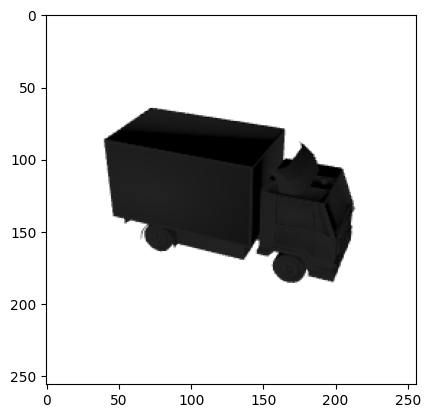

In [30]:
check_output(output[0], images[0], epoch=epoch, batch=i)

519


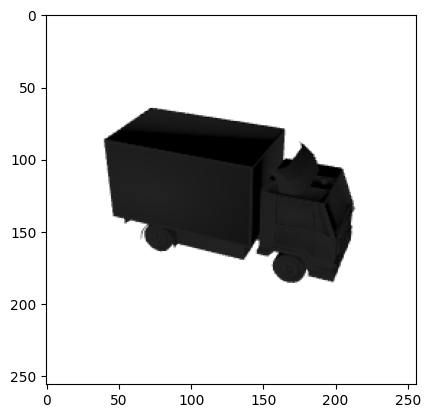

In [34]:
check_normal_output(model(images).squeeze(1)[0], images[0], threshold=0.5, epoch=1000, batch=1000)

In [34]:
model(images[1].unsqueeze(0).to(device)).shape

torch.Size([1, 1, 16, 16, 16])

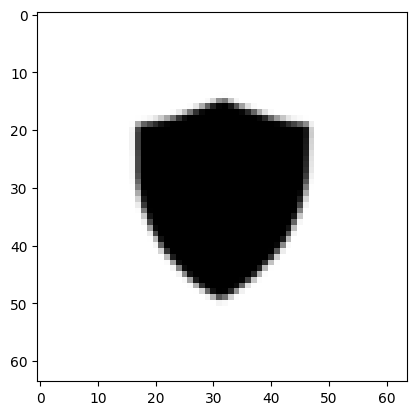

In [122]:
check_output(output[4], images[4], epoch=0)

In [123]:
output[4]

tensor([[[8.8006e-02, 2.0144e-01, 2.9009e-01,  ..., 8.9391e-02,
          7.4145e-02, 3.3514e-02],
         [1.3633e-01, 2.3901e-01, 2.7001e-01,  ..., 7.4983e-02,
          7.2419e-02, 3.8240e-02],
         [1.6877e-01, 2.6712e-01, 2.8253e-01,  ..., 6.7611e-02,
          9.0792e-02, 3.1234e-02],
         ...,
         [3.1964e-02, 5.0868e-02, 5.6639e-02,  ..., 3.3566e-04,
          1.1422e-03, 3.9571e-04],
         [2.1923e-02, 2.8927e-02, 4.5737e-02,  ..., 2.8116e-04,
          5.6690e-03, 5.9631e-03],
         [5.7261e-03, 1.4686e-02, 1.9347e-02,  ..., 2.8720e-04,
          4.6226e-03, 5.4296e-03]],

        [[9.8284e-02, 1.8116e-01, 2.5352e-01,  ..., 1.0125e-01,
          7.2335e-02, 3.6770e-02],
         [1.5201e-01, 2.3681e-01, 3.1123e-01,  ..., 9.2363e-02,
          7.7043e-02, 4.3951e-02],
         [1.8236e-01, 3.0570e-01, 2.8118e-01,  ..., 5.4563e-02,
          7.2248e-02, 3.4171e-02],
         ...,
         [2.5424e-02, 4.2590e-02, 6.6943e-02,  ..., 3.1306e-04,
          6.449

In [144]:
objects[0][0]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 